# Описание проекта

Нам следует разобраться, как ведут себя пользователи нашего мобильного приложения, в которым продают продукты питания.

Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно.

После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выяснить, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

# Описание данных

Каждая запись в логе — это действие пользователя, или событие. 

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Содержание

1. Загрузка данных
2. Предобработка данных
3. Изучение и проверка данных
4. Изучение воронки событий
5. Изучение результатов эксперимента

## Загрузка данных

Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import math as mth

In [2]:
import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2

Открытие файла

In [3]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
df.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Предобработка данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Приведем название столбцов к нижнему и "змеиному" регистру

In [5]:
df.columns = ['event_name', 'user_id', 'event_timestamp', 'exp_id']
df.head(5)

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Проверим таблицу на наличие дубликатов

In [6]:
df.duplicated().sum()

413

Вряд ли один и тот же пользователь в одной группе совершал одинаковые события в одно и тоже время

Удалим дубликаты

In [7]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

Проверим таблицу на наличие пропусков

In [8]:
df.isna().sum()

event_name         0
user_id            0
event_timestamp    0
exp_id             0
dtype: int64

Создадим столбец "datetime" с датой и временем

In [9]:
df['datetime'] = pd.to_datetime(df['event_timestamp'], unit='s')
df.head(5)

,event_name,user_id,event_timestamp,exp_id,datetime
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


Добавим столбец с датой

In [10]:
df['date'] = df['datetime'].dt.date
df.head(5)

,event_name,user_id,event_timestamp,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   datetime         243713 non-null  datetime64[ns]
 5   date             243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


В столбеце "date" поменяем тип на "datetime64"

In [12]:
df['date'] = df['date'].astype('datetime64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   datetime         243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


Проверим группы на совпадения пользователей

In [13]:
df.groupby('exp_id').agg({'user_id': 'nunique'})

,user_id
exp_id,
246,2489
247,2520
248,2542


In [14]:
print('Количество пользователей, попавших в несколько групп:',\
      df.groupby('user_id').agg({'exp_id': 'nunique'}).query('exp_id > 1').count()[0])

Количество пользователей, попавших в несколько групп: 0


В каждой группе примерно однаковое число пользователей. Пользователей которые могли попасть не только в одну группу - нет.

**Вывод:**

Проведена предобработка таблицы. Всё готово к анализу


## Изучение и проверка данных

### Количество событий в логе

In [15]:
df['exp_id'].value_counts()

248    85582
246    80181
247    77950
Name: exp_id, dtype: int64

In [16]:
all_events = df['exp_id'].count()
print('Всего событий в таблице =', all_events)

Всего событий в таблице = 243713


### Количество пользователей в логе

In [17]:
users = df['user_id'].nunique()
print('Уникальных пользователей в таблице =', users)

Уникальных пользователей в таблице = 7551


### Среднее кол-во событий на пользователя

In [18]:
print("Среднее кол-во событий на пользователя =", (all_events / users).round(1))

Среднее кол-во событий на пользователя = 32.3


Так как среднее арифметическое чувствительно к возможным выбросам в данных и может под их влиянием как уменьшаться, так и увеличиваться, необходимо проверить как описаны данные.

In [19]:
df.groupby('user_id').agg({'event_name': 'count'}).describe()

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


Поскольку 75% перцентиль распределения числа событий на пользователя равен всего 37, а максимальное значение событий на одного пользователя равно 2307, можно сказать, что присутствуют выбросы и для расчета среднего лучше использовать медиану.

In [20]:
print("Медианное кол-во событий на пользователя =", round(df.groupby('user_id').agg({'event_name': 'count'}).median()[0], 1))

Медианное кол-во событий на пользователя = 20.0


### Распределение данных во времени

Найдем максимальную и минимальную дату.

In [21]:
print('Минимальная дата наблюдений:', df['datetime'].min())
print('Максимальная дата наблюдений:', df['datetime'].max())

Минимальная дата наблюдений: 2019-07-25 04:43:36
Максимальная дата наблюдений: 2019-08-07 21:15:17


Построим гистограмму по дате и времени

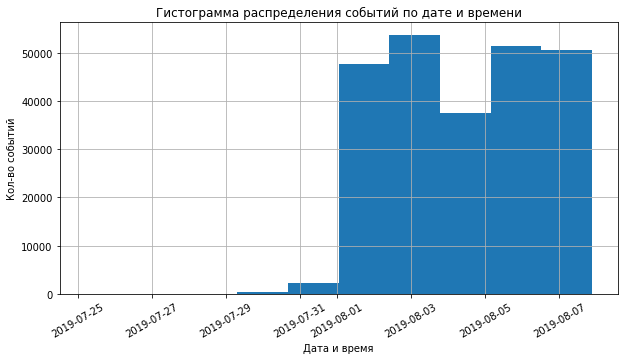

In [22]:
df['datetime'].hist(figsize=(10, 5))
plt.xlabel('Дата и время')
plt.ylabel('Кол-во событий')
plt.title('Гистограмма распределения событий по дате и времени')
plt.xticks(rotation=30)
plt.show()

Основная масса логов приходится на период с 1 по 7 августа 2019.

Судя по гистограмме более логично анализировать период данных 1-7.08.2019, записи до этой даты могли появиться ввиду разницы в часовых поясах или же пользователь мог начать сессию в один день и закончить на следующий, таким образом логично будет отбросить все записи до 1 августа.

In [23]:
df = df.query('date >= "2019-08-01"')
print('Новая минимальная дата наблюдений:', df['datetime'].min())

Новая минимальная дата наблюдений: 2019-08-01 00:07:28


### Количество отброшенных данных

In [24]:
print(f'Потеряли {all_events - len(df)} событий, что являлось {round((all_events - len(df)) / all_events * 100, 2)}% от общего числа данных')

Потеряли 2826 событий, что являлось 1.16% от общего числа данных


In [25]:
print(f"Потеряли {users - df['user_id'].nunique()} пользователей, что являлось {round((users - df['user_id'].nunique()) / users * 100, 2)}% от общего числа пользователей")

Потеряли 17 пользователей, что являлось 0.23% от общего числа пользователей


Как видно удаленные данные составляли малую часть от общего кол-ва данныз, значит их удаление не повлияет на дальнейшие результаты анализа.

### Проверка пользователей в группах

In [26]:
df['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

In [27]:
df.groupby('exp_id')['user_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

В каждой группе примерно по 2,5 тысячи пользователей.

## Изучение воронки событий

### Изучим, какие события есть в логах, как часто они встречаются.

In [28]:
df.groupby('event_name')['event_name'].count().sort_values(ascending=False)

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Чтобы было понятнее, приведем перевод названий событий:

- MainScreenAppear - Появление главного экрана
- OffersScreenAppear - Появление экрана предложений
- CartScreenAppear - Появление экрана корзины
- PaymentScreenSuccessful - экран платеж успешен
- Tutorial - Руководство пользователя

Всего в логе встречается 5 событий. Самое распространенное это "Появление главного экрана", наименее распространенное "руководство пользователя".

### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [29]:
events_by_users = df.groupby('event_name').agg({'user_id': 'nunique'}).sort_values('user_id', ascending=False).reset_index()
events_by_users.columns = ['event_name', 'cnt_users']
events_by_users


,event_name,cnt_users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [30]:
events_by_users['share'] = events_by_users['cnt_users'] / df['user_id'].nunique()
events_by_users.style.format({'share':'{:.2%}'})

,event_name,cnt_users,share
0,MainScreenAppear,7419,98.47%
1,OffersScreenAppear,4593,60.96%
2,CartScreenAppear,3734,49.56%
3,PaymentScreenSuccessful,3539,46.97%
4,Tutorial,840,11.15%


98% пользователей попадают на главный экран, почти 50% на экран оплаты и 47% на экран "оплата прошла успешно". Значит около 3% пользователей при оплате заказа где-то теряется. В любом случае на первый взгляд показатель конверсии довольно высок.

### Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Событие "Руководство пользователя" не входит в воронку, вероятно к нему можно обратиться в любой момент и пользователи редко пользуются этим шагом. Последовательная воронка будет выглядеть так:

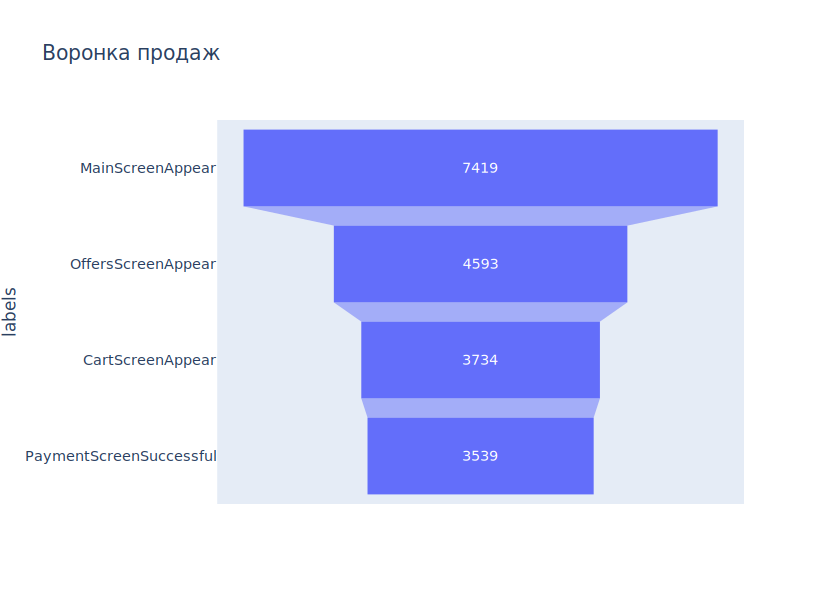

In [31]:
funnel = events_by_users[['event_name', 'cnt_users']].query('event_name != "Tutorial"')
data = dict(values=funnel['cnt_users'].to_list(),
            labels=funnel['event_name'].to_list())
fig = px.funnel(data,  y='labels', x='values', title='Воронка продаж')
fig.show()

### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

Для последовательности событий A → B → C, посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [32]:
funnel['conversion_per_step'] = 0

for index in range(0, len(funnel)):
    if index == 0:
        funnel.loc[index, 'conversion_per_step'] = 100
    else:
        funnel.loc[index, 'conversion_per_step'] = round(funnel.loc[index, 'cnt_users'] * 100 / funnel.loc[index - 1, 'cnt_users'], 2)
funnel

,event_name,cnt_users,conversion_per_step
0,MainScreenAppear,7419,100.00
1,OffersScreenAppear,4593,61.91
2,CartScreenAppear,3734,81.30
3,PaymentScreenSuccessful,3539,94.78


Больше всего пользователей теряется при переходе от главного экрана к экрану с предложением, не доходит около 40%. Если в мобильном приложении есть опция сразу отправлять товар в корзину, не заходя на страницу с продуктом, это может объяснить высокую конверсию в 80% на следующем шаге.

### Посчитаем какая доля пользователей доходит от первого события до оплаты?

In [33]:
funnel['conversion'] = 0

for index in range(0, len(funnel)):
    if index == 0:
        funnel.loc[index, 'conversion'] = 100
    else:
        funnel.loc[index, 'conversion'] = round(funnel.loc[index, 'cnt_users'] * 100 / funnel.loc[0, 'cnt_users'], 2)
funnel

,event_name,cnt_users,conversion_per_step,conversion
0,MainScreenAppear,7419,100.00,100.00
1,OffersScreenAppear,4593,61.91,61.91
2,CartScreenAppear,3734,81.30,50.33
3,PaymentScreenSuccessful,3539,94.78,47.70


От страницы главного экрана до оплаты доходит почти 48% пользователей.

## Изучение результатов эксперимента

### Посчитаем сколько пользователей в каждой экспериментальной группе

In [34]:
df.groupby('exp_id').agg({'user_id': 'nunique'})

,user_id
exp_id,
246,2484
247,2513
248,2537


### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

Cамое популярное событие как мы выяснили ранее было появление главного экрана

In [35]:
check_groups = df.query('event_name == "MainScreenAppear" & (exp_id == 246 | exp_id == 247)').groupby('exp_id').agg({'user_id':'nunique'})
check_groups.columns = ['count_users']
total_246 = df.query('exp_id == 246')['user_id'].nunique()
total_247 = df.query('exp_id == 247')['user_id'].nunique()
check_groups.loc[246, 'share_users'] = check_groups.loc[246, 'count_users'] / total_246
check_groups.loc[247, 'share_users'] = check_groups.loc[247, 'count_users'] / total_247
check_groups.style.format({'share_users':'{:.2%}'})

,count_users,share_users
exp_id,,
246,2450,98.63%
247,2476,98.53%


Перед тем как начать A/B-тест уточним:

- на результаты не влияют аномалии и выбросы в генеральной совокупности;
- инструмент «деления» трафика работает безошибочно;
- данные отправляются в системы аналитики корректно.

Для этого проводят A/A-тест. Он похож на A/B-тест, только группам показывают не разные, а одинаковые версии страниц. Если трафик и инструмент проведения A/A-теста не подвели, различий в показателях не будет. Ещё А/А-тест помогает определить длительность теста и методику анализа данных.

Критерии успешного A/A-теста:

- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

Сформулируем гипотезы:

**Нулевая гипотеза: различий в долях проверяемых событий групп 246 и 247 нет**

**Альтернативная гипотеза: между долями проверяемых событий групп 246 и 247 есть значимая разница**

**Уровень стастической значимости равен 5%**

**Тест (критерий) проверки гипотез - Односторонний тест (критерий)**

Если p-значение <= alpha (уровень стастической значимости), мы отвергаем нулевую гипотезу и говорим, что данные статистически значимы. в противном случае мы принимаем нулевую гипотезу.



In [36]:
# напишем функцию для автоматизации теста
def test_z(group1, group2, event, alpha):

    def successes_trials(group1, group2, event):
    
        successes = np.array([df.query(f'exp_id == {group1} & event_name == "{event}"')['user_id'].nunique(),\
                          df.query(f'exp_id == {group2} & event_name == "{event}"')['user_id'].nunique()])

        trials = np.array([df.query(f'exp_id == {group1}')['user_id'].nunique(),\
                           df.query(f'exp_id == {group2}')['user_id'].nunique()])
        return successes, trials
    
    successes, trials = successes_trials(group1, group2, event) 
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
 
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
 
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
 
    # разница пропорций в датасетах
    difference = p1 - p2 
 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
 
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1) 
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(f'Результаты теста для групп {group1} и {group2} и события {event}')
 
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [37]:
test_z(246, 247, 'MainScreenAppear', 0.05)

Результаты теста для групп 246 и 247 и события MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [38]:
test_z(246, 247, 'OffersScreenAppear', 0.05)

Результаты теста для групп 246 и 247 и события OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [39]:
test_z(246, 247, 'CartScreenAppear', 0.05)

Результаты теста для групп 246 и 247 и события CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [40]:
test_z(246, 247, 'PaymentScreenSuccessful', 0.05)

Результаты теста для групп 246 и 247 и события PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Согласно проведенным тестам, различие между контрольными группа 246 и 247 статистически незначимо, поэтому можно сказать, что разбиение на группы работает корректно.

**Аналогично поступим с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?**

Сформулируем гипотезы:

**Нулевая гипотеза: различий в долях проверяемых событий групп 246 и 248 нет**

**Альтернативная гипотеза: между долями проверяемых событий групп 246 и 248 есть значимая разница**

**Уровень стастической значимости равен 5%**

**Тест (критерий) проверки гипотез - Односторонний тест (критерий)**

Если p-значение <= alpha (уровень стастической значимости), мы отвергаем нулевую гипотезу и говорим, что данные статистически значимы. в противном случае мы принимаем нулевую гипотезу.

In [41]:
# сравним контрольную 246 группу и экспериментальную 248
test_z(246, 248, 'MainScreenAppear', 0.05)
print()
test_z(246, 248, 'OffersScreenAppear', 0.05)
print()
test_z(246, 248, 'CartScreenAppear', 0.05)
print()
test_z(246, 248, 'PaymentScreenSuccessful', 0.05)

Результаты теста для групп 246 и 248 и события MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 246 и 248 и события OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 246 и 248 и события CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 246 и 248 и события PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем гипотезы:

**Нулевая гипотеза: различий в долях проверяемых событий групп 247 и 248 нет***

**Альтернативная гипотеза: между долями проверяемых событий групп 247 и 248 есть значимая разница**

**Уровень стастической значимости равен 5%**

**Тест (критерий) проверки гипотез - Односторонний тест (критерий)**

Если p-значение <= alpha (уровень стастической значимости), мы отвергаем нулевую гипотезу и говорим, что данные статистически значимы. в противном случае мы принимаем нулевую гипотезу.

In [42]:
# сравним контрольную 247 группу и экспериментальную 248
test_z(247, 248, 'MainScreenAppear', 0.05)
print()
test_z(247, 248, 'OffersScreenAppear', 0.05)
print()
test_z(247, 248, 'CartScreenAppear', 0.05)
print()
test_z(247, 248, 'PaymentScreenSuccessful', 0.05)

Результаты теста для групп 247 и 248 и события MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 247 и 248 и события OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 247 и 248 и события CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 247 и 248 и события PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Немного изменим функцию для автоматизации теста, чтобы в агрументе group1 функции можно было передавать параметр в виде списка групп

In [43]:
def test_z_3_groups(group1, group2, event, alpha):

    def successes_trials_3_groups(group1, group2, event):
    #изменили вот тут
        successes = np.array([df.query(f'exp_id.isin({group1}) & event_name == "{event}"')['user_id'].nunique(),\
                              df.query(f'exp_id == {group2} & event_name == "{event}"')['user_id'].nunique()])
    #и вот тут
        trials = np.array([df.query(f'exp_id.isin({group1})')['user_id'].nunique(),\
                           df.query(f'exp_id == {group2}')['user_id'].nunique()])
        return successes, trials
    
    successes, trials = successes_trials_3_groups(group1, group2, event) 
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
 
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
 
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
 
    # разница пропорций в датасетах
    difference = p1 - p2 
 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
 
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1) 
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(f'Результаты теста для групп {group1} и {group2} и события {event}')
 
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Сформулируем гипотезы:

**Нулевая гипотеза: различий в долях проверяемых событий между объединенными контрольными группами 246, 247 и контрольной 248 нет**

**Альтернативая гипотеза: между долями проверяемых событий контрольных групп 246, 247 и контрольной группой 248 есть значимая разница**

**Уровень стастической значимости равен 5%**

**Тест (критерий) проверки гипотез - Односторонний тест (критерий)**

Если p-значение <= alpha (уровень стастической значимости), мы отвергаем нулевую гипотезу и говорим, что данные статистически значимы. в противном случае мы принимаем нулевую гипотезу.

In [44]:
test_z_3_groups([246, 247], 248, 'MainScreenAppear', 0.05)
print()
test_z_3_groups([246, 247], 248, 'OffersScreenAppear', 0.05)
print()
test_z_3_groups([246, 247], 248, 'CartScreenAppear', 0.05)
print()
test_z_3_groups([246, 247], 248, 'PaymentScreenSuccessful', 0.05)

Результаты теста для групп [246, 247] и 248 и события MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп [246, 247] и 248 и события OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп [246, 247] и 248 и события CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп [246, 247] и 248 и события PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Согласно проведенным тестам различия между контрольными группами 246 и 247 и экспериментальной 248 являются статистически незначимыми. Таким образом можно сказать, что изменение шрифтов во всем приложении не повлияло на воронку продаж, и пользователи переходят от шага к шагу в одинаковых пропорциях, независимо от шрифта приложения.

**Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.**

Всего было проведено 16 статистических тестов, уровень значимости везде был равен 5%. Несмотря на то, что тесты были множественные, т.е. проводились несколько раз на одних и тех же данных, использовать методы корректировки уровня значимости нецелесообразно, так как в нашем случае уже при уровне значимости в 5% нулевые гипотезы не отвергаются, следовательно при уменьшении уровня значимости они не отвергались бы тем более.

**Вывод:**



В ходе проведенного анализа результатов A/A/B-теста за период 1.08.2019 по 7.08.2019 было выявлено следующее:

- в среднем на одного пользователя приходится 20 событий;

- 98% от общего числа пользователей посещают главный экран, из них 61% переходит на экран с предложением, далее в корзину попадает 81% и наконец оплачивают заказ 94%, при этом непосредственно от первого события до оплаты доходит 47%;

- по проведенным статистическим тестам различий в двух контрольных группах не выявлено, это говорит о том что данные собраны качественно и результатам A/A/B-теста можно доверять;

- по проведенным статистическим тестам различий между контрольными группа и экспериментальной также не выявлено, как при сравнении по отдельности так и при объединении контрольных групп в одну.

Исходя из проведенного анализа можно сделать вывод, что на основании корректно проведенного A/A/B-теста изменение шрифтов в приложении не повлияло на поведение пользователей.